In [3]:
import pandas as pd
%matplotlib notebook
import numpy as np

In [5]:
mpu6000 = pd.read_csv('imu_coupler_bay/mpu6000.csv', index_col='time')

/usr/local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
t_start = 9380
t_end = 9800
liftoff = 9584.25
burnout = 9588.8
apogee = 9609
separation = 9610.5
touchdown = 9702.1
mpu6000 = mpu6000[t_start:t_end]

acc_calib = { # (bias, gain), acc = (sensor - bias) / gain
'x': (0.12570896416609578, 0.9984256389897912),
'y': (0.0031463042356696391, 0.99443041010383559),
'z': (-0.028494989398200055, 1.0144324415852917),
}
gyro_bias = mpu6000[liftoff-30:liftoff-5].mean()[['gyro_'+a for a in ['x', 'y', 'z']]]

In [54]:
imu = pd.DataFrame()
for axis in ['x', 'y', 'z']:
    imu['acc_'+axis] = (mpu6000[liftoff-10:touchdown+10]['acc_'+axis] - acc_calib[axis][0])/acc_calib[axis][1]
    imu['rate_'+axis] = (mpu6000[liftoff-10:touchdown+10]['gyro_'+axis]) - gyro_bias['gyro_'+axis]

In [56]:
imu = imu[~imu.index.duplicated(keep='first')] #remove duplicated timestamps for nonzero dt between frames

In [57]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from quaternion import Quaternion
att = Quaternion([1,0,0,0])
prev_t = imu.index[0]
for t,frame in imu.iterrows():
    dt = t - prev_t
    prev_t = t
    imu.loc[t, 'dt'] = dt
    for i in range(4):
        imu.loc[t, 'q'+str(i)] = att.q[i]
    delta_att = Quaternion([1] + [dt / 2 * r for r in [frame.rate_x, frame.rate_y, frame.rate_z]])
    att = (att * delta_att).normalized()
    

In [58]:
# inertia and masses
m_liftoff = 24.794 # [kg]
m_burnout = 20.846 # [kg]
CM_liftoff = 1.728 # [m]
CM_burnout = 1.601 # [m]
Iz_liftoff = 0.0782 # [kgm2]
Iz_burnout = 0.0743 # [kgm2]
Ixy_liftoff = 11.407 # [kgm2]
Ixy_burnout =  9.190 # [kgm2]

def mass(time):
    if time < liftoff:
        return {'m':m_liftoff, 'CM':CM_liftoff, 'Iz':Iz_liftoff, 'Ixy':Ixy_liftoff}
    if time > burnout:
        return {'m':m_burnout, 'CM':CM_burnout, 'Iz':Iz_burnout, 'Ixy':Ixy_burnout}
    a = (time - liftoff)/(burnout-liftoff)
    return {'m':m_liftoff + a * (m_burnout-m_liftoff),
            'CM':CM_liftoff + a * (CM_burnout-CM_liftoff),
            'Iz':Iz_liftoff + a * (Iz_burnout-Iz_liftoff),
            'Ixy':Ixy_liftoff + a * (Ixy_burnout-Ixy_liftoff)}



In [59]:
# compensate for imu position with respect to CM
# assuming imu axes are aligned with the rocket
imu_pos = np.array([0.0, 0.0, 1.782-0.050])
imu_offset = lambda time: imu_pos - np.array([0, 0, mass(time)['CM']])
for a in ['x', 'y', 'z']:
    imu['rate_dot_'+a] = imu['rate_'+a].diff()/imu['dt']
    
# acceleration due to angular acceleration
#  a_rate_dot = rate_dot x imu_offset
# acceleration due to rotation (centripetal)
#  a_centripetal = - |rate_tangential|^2 * imu_offset
#  where rate_tangential is the tangential rate obtained by
#   rate - (dot(rate, imu_offset)/|imu_offset|^2 * imu_offset)
for t,i in imu.iterrows():
    r = imu_offset(t)
    rate_dot = np.array([i.rate_dot_x, i.rate_dot_y, i.rate_dot_z])
    a_rate_dot = np.cross(rate_dot, r)
    rate = np.array([i.rate_x, i.rate_y, i.rate_z])
    rate_tangential = rate - np.dot(rate, r)/np.dot(r,r)*r
    a_centripetal = - r * np.dot(rate_tangential, rate_tangential)
    imu.loc[t, 'a_rate_dot_x'] = a_rate_dot[0]
    imu.loc[t, 'a_rate_dot_y'] = a_rate_dot[1]
    imu.loc[t, 'a_rate_dot_z'] = a_rate_dot[2]
    imu.loc[t, 'a_centripetal_x'] = a_centripetal[0]
    imu.loc[t, 'a_centripetal_y'] = a_centripetal[1]
    imu.loc[t, 'a_centripetal_z'] = a_centripetal[2]

In [60]:
for a in 'xyz':
    imu['acc_cm_'+a] = imu['acc_'+a] - imu['a_rate_dot_'+a] - imu['a_centripetal_'+a]

<IPython.core.display.Javascript object>


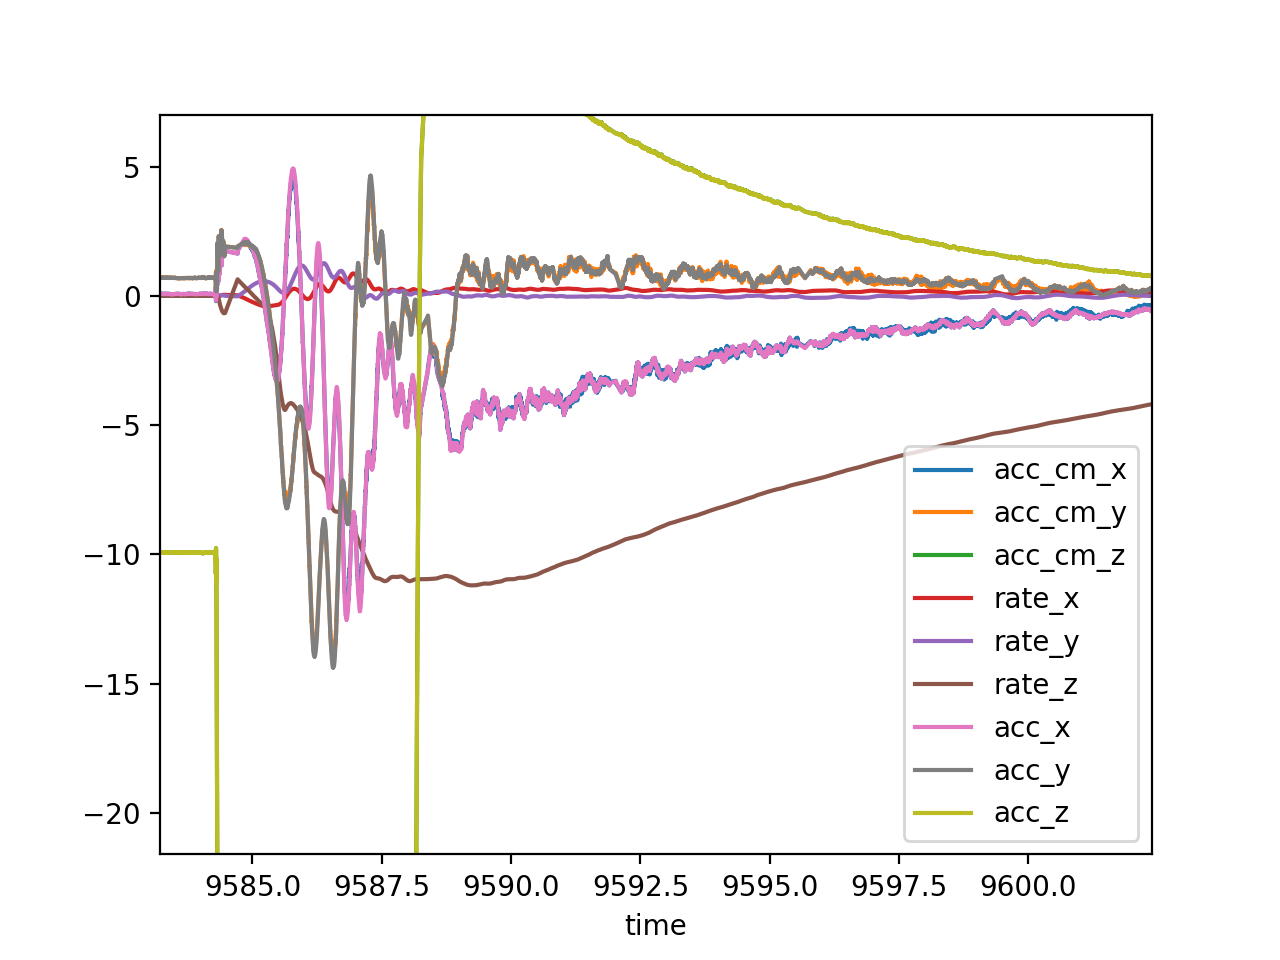

In [70]:
imu[['acc_cm_'+a for a in 'xyz'] + ['rate_'+a for a in 'xyz'] + ['acc_'+a for a in 'xyz']].plot()

In [72]:
# compute external torque (in body axes) acting on the rocket (by rigid body dynamics)
for t,i in imu.iterrows():
    m = mass(t)
    Ixy = m['Ixy']
    Iz = m['Iz']
    imu.loc[t, 'M_x'] = Ixy*i.rate_dot_x + (Iz-Ixy)*i.rate_y*i.rate_z
    imu.loc[t, 'M_y'] = Ixy*i.rate_dot_y + (Ixy-Iz)*i.rate_z*i.rate_x
    imu.loc[t, 'M_z'] = Iz*i.rate_dot_z

In [73]:
# Compute the torque due to side forces assuming they are aerodynamic
# and thus act at the CP
CP = 1.959 # [m]
for t,i in imu.iterrows():
    m = mass(t)
    Fx = i.acc_cm_x * m['m']
    Fy = i.acc_cm_y * m['m']
    imu.loc[t, 'M_aero_x'] = (CP - m['CM']) * (-Fy)
    imu.loc[t, 'M_aero_y'] = (CP - m['CM']) * Fx

<IPython.core.display.Javascript object>


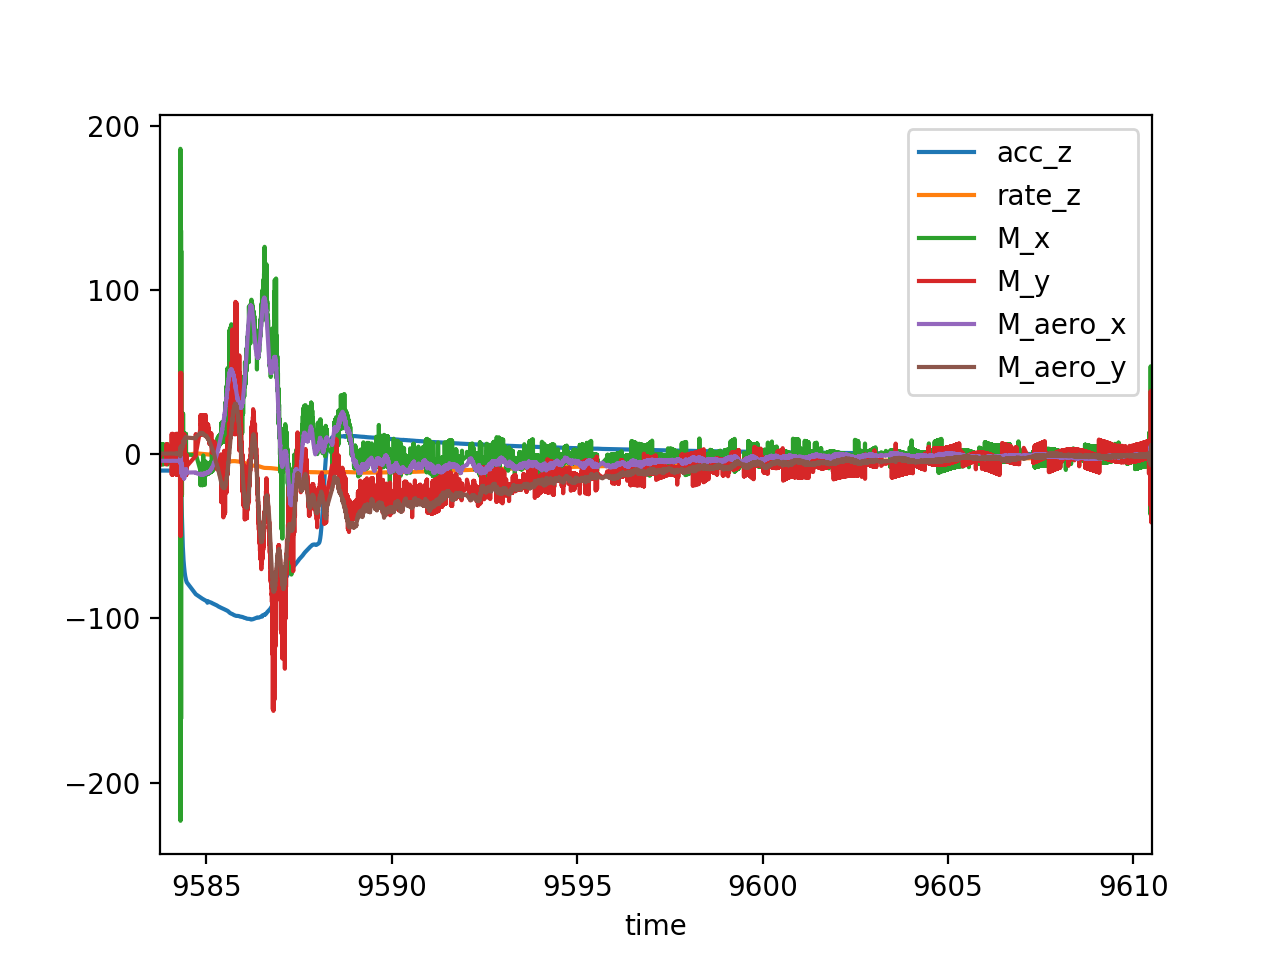

In [74]:
imu[['acc_'+a for a in 'z']+['rate_z']+['M_'+a for a in 'xy']+['M_aero_'+a for a in 'xy']][liftoff-0.5:separation].plot()

In [80]:
imu[['q'+str(i) for i in range(4)]+['acc_cm_'+a for a in 'xyz']].to_csv('imu.csv')

In [9]:
ms5611 = pd.read_csv('imu_coupler_bay/ms5611.csv', index_col='time')[t_start:t_end]

<IPython.core.display.Javascript object>


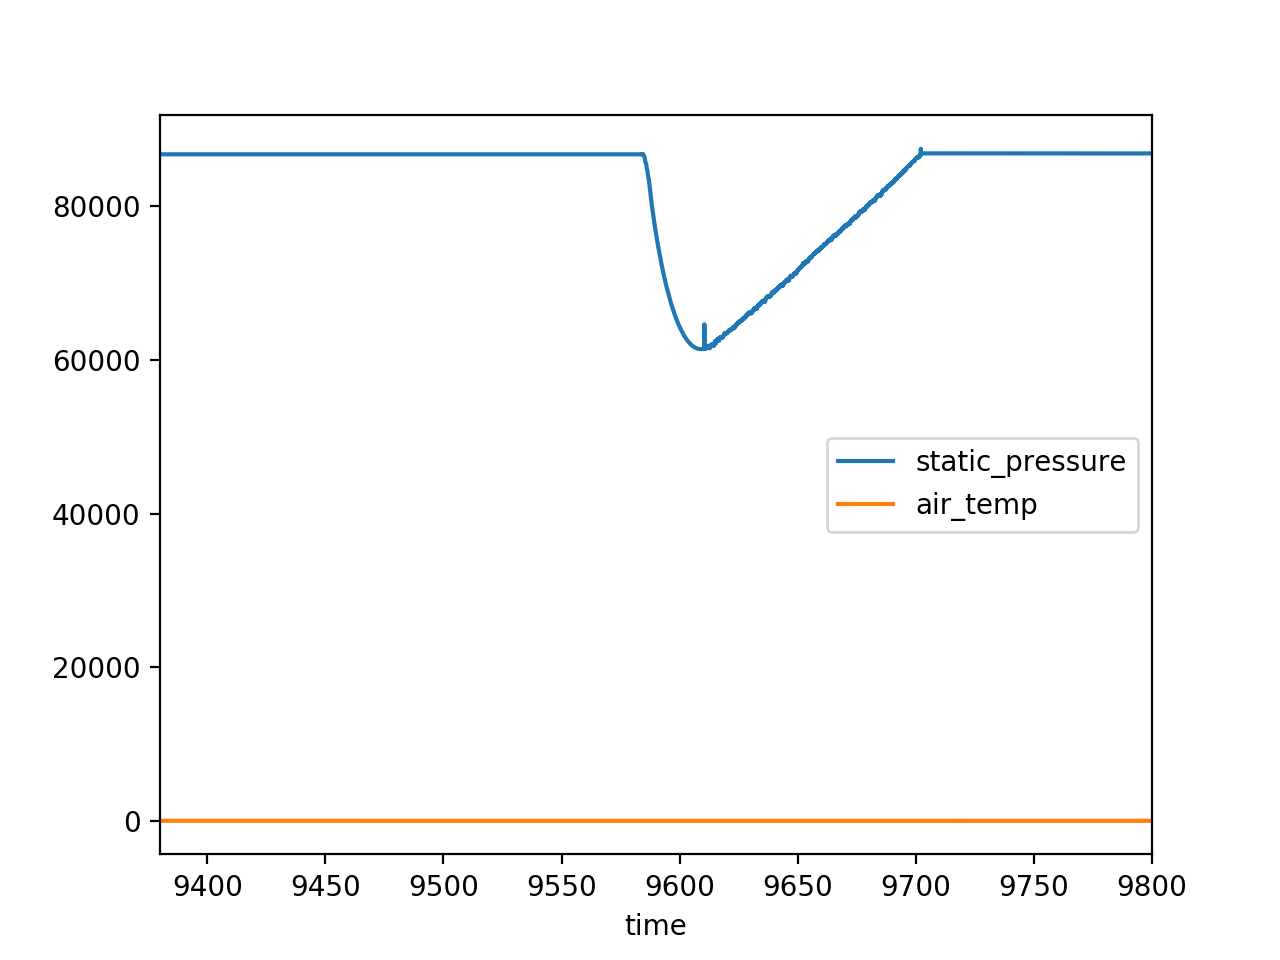

In [10]:
ms5611.plot()

<IPython.core.display.Javascript object>


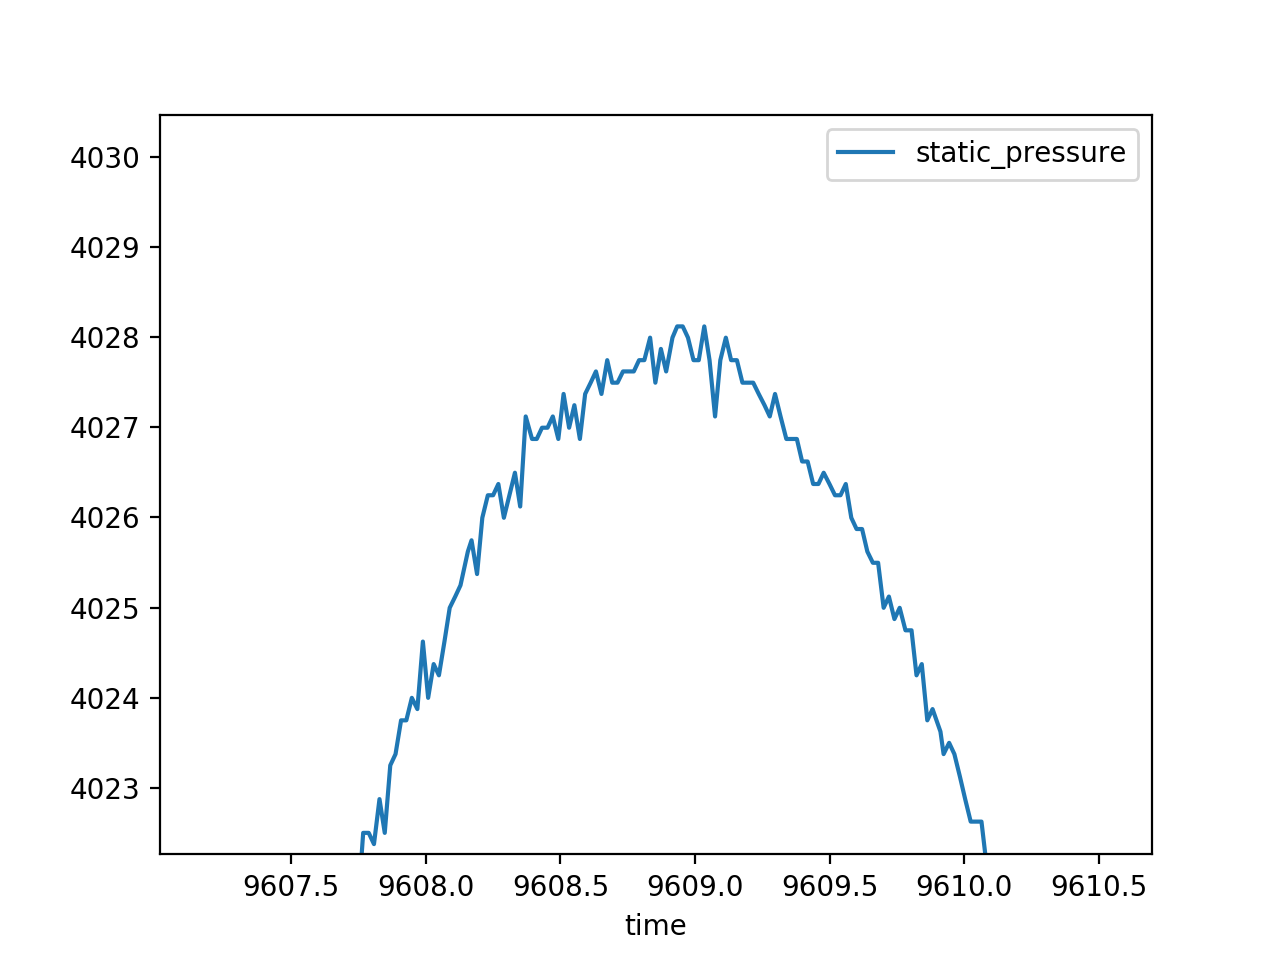

In [25]:
altitude = 44330.8 - 4946.54 * pd.DataFrame(ms5611['static_pressure'])**0.1902632;
altitude.plot()

<IPython.core.display.Javascript object>


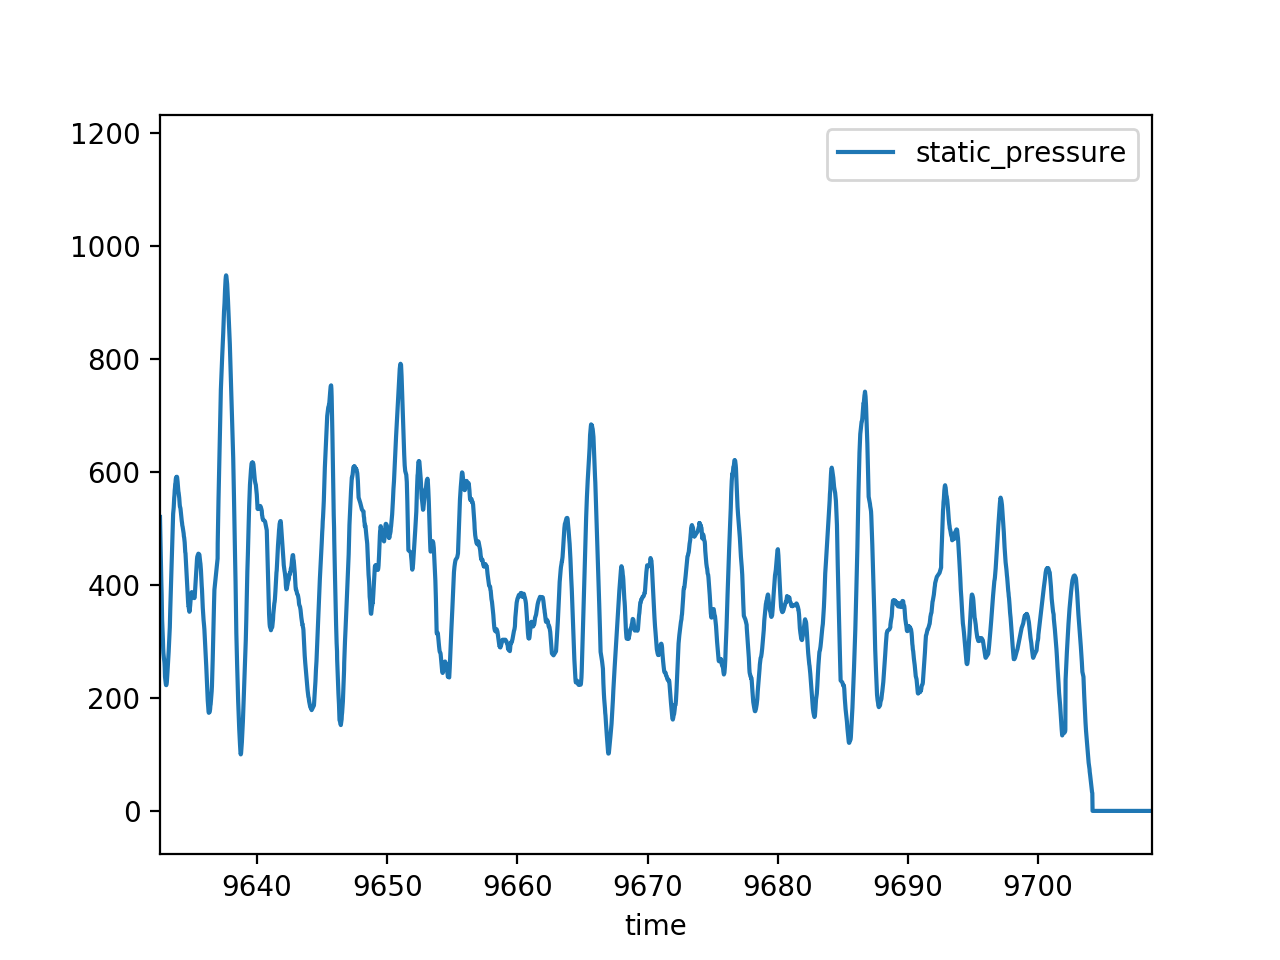

In [26]:
r = altitude.rolling(100).var().plot()

/usr/local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<IPython.core.display.Javascript object>


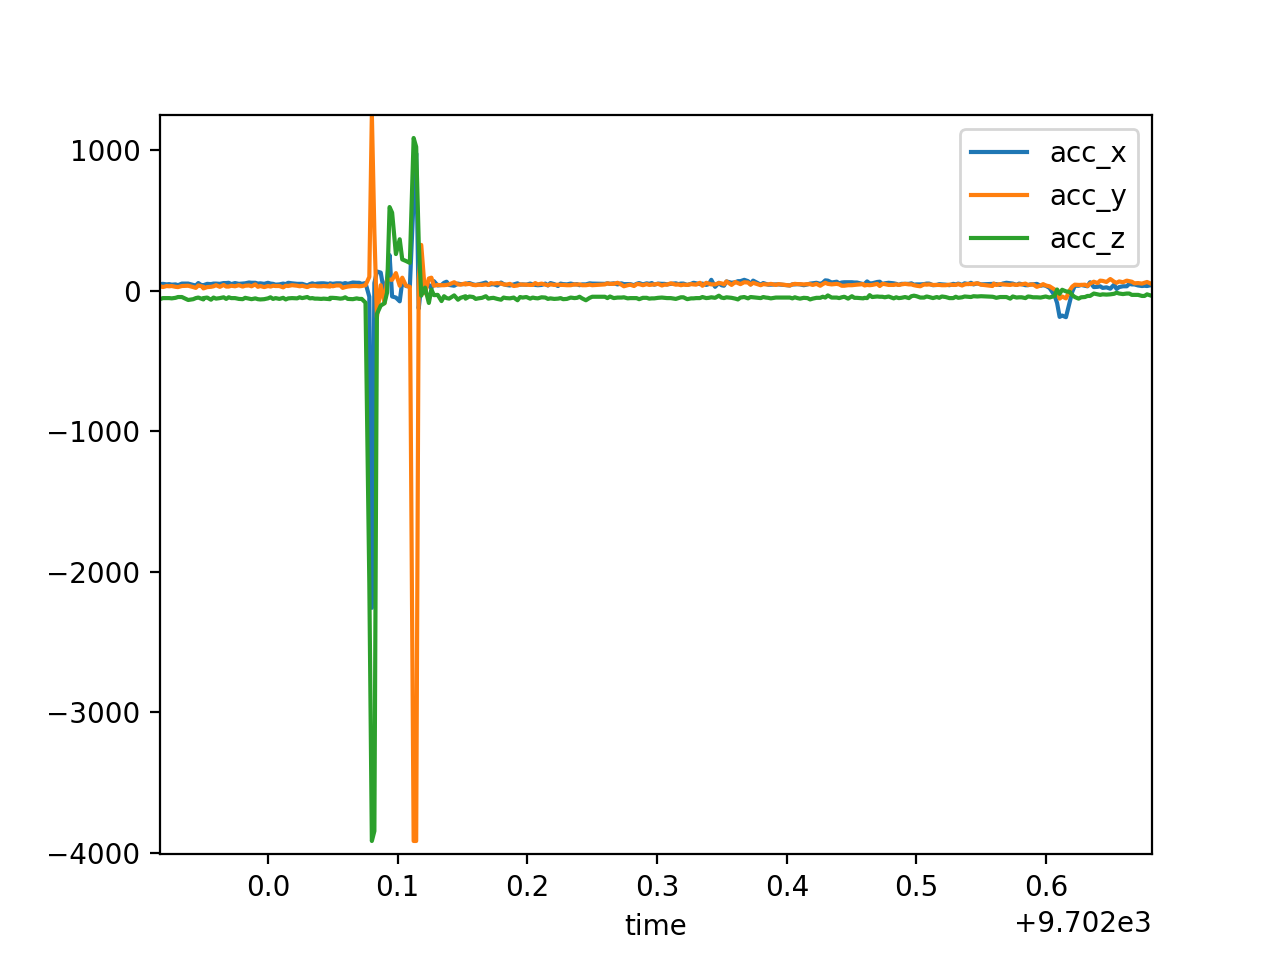

In [14]:
h3lis331dl = pd.read_csv('h3lis331dl.csv', index_col='time')[t_start:t_end]
h3lis331dl.plot()

In [52]:
d=pd.DataFrame(index=[0.1,0.2,0.3,0.3,0.4,0.5], data=[1,2,3,4,5,6])
d[~d.index.duplicated(keep='first')]

,0
0.1,1
0.2,2
0.3,3
0.4,5
0.5,6


In [53]:
prev_t = d.index[0]
for t,frame in d.iterrows():
    dt = t - prev_t
    print(t, dt)
    d.loc[t, 'dt'] = dt
    prev_t = t

0.1 0.0
0.2 0.1
0.3 0.1
0.3 0.0
0.4 0.1
0.5 0.1


In [44]:
d

,0,dt
0.1,1,0.0
0.2,2,0.1
0.3,3,0.0
0.3,4,0.0
0.4,5,0.1
0.5,6,0.1
